# **<font color="#FBBF44">Imports</font>**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# !pip install gurobipy
import gurobipy as gp
from gurobipy import Model, GRB, quicksum

# **<font color="#FBBF44">Functions</font>**

In [2]:
# Time limits for different sets of instances
timelimCHU = 1200
# To store runtimes and objective values
times = []
objectives = []

# Cost factors for large and Small vehicles
a1 = np.random.randint(5,10)/10 # = .8
a2 = a1*.75 # = .6

# Instance generator
def instance_gen(seed, clients, S1, S2, Q1, dmin, dmax):
    np.random.seed(seed) # Initial seed
    n = clients # number of clients
    # random location of clients within 8km radius
    xc = np.random.rand(n+1)*8 
    yc = np.random.rand(n+1)*8
    points = range(0,n+1)

    N = [i for i in range(1, n + 1)] # Set of clients
    V = [0] + N # Set of all nodes, including depot
    A = [(i,j) for i in V for j in V if i != j] # Available arcs between nodes
    
    S = S1 + S2 # Total amount of available vehicles
    K = [i for i in range(1, S + 1)] # Number of available vehicles, including large and small
    K1 = [i for i in range(1, S1 + 1)] # subset of large vehicles
    K2 = [i for i in range(S1+1, S1+S2+1)] # subset of small vehicles
    
    Ak = [(i,j,k) for k in K for i in V for j in V if i != j] # Available arcs between nodes for each vehicle
    Q = {} # Capacities
    for i in K:
        if i in K1:
            Q[i] = Q1 
        else:
            Q[i] = Q1/2

    d = {i: np.random.randint(dmin, dmax) for i in N} # Random demands from customers

    a1 = .8
    a2 = .6

    d1 = {(i,j,1): (np.hypot(xc[i] - xc[j], yc[i] - yc[j])) + np.random.rand() for i, j in A}
    d2 = {(i,j,2): d1[i,j,1] for i, j in A}
    c1 = {k:v*a1 for k, v in d1.items()} # Cost for traversing i,j with LargeVehicle
    c2 = {k:v*a2 for k, v in d2.items()} # Cost for traversing i,j with SmallVehicle
    c = dict(c1)
    c.update(c2) 
    return n, xc, yc, points, list(N), V, K, K1, K2, A, Ak, S, Q, d, c

In [3]:
# Building the model
def build_model(model):
    model = gp.Model()
    x = model.addVars(A, K, vtype=GRB.BINARY, name = "x") # x[i,j,k] = equals to 1 if vehicle k traverses i,j, 0 otherwise
    y = model.addVars(N, K, vtype=GRB.INTEGER, name = "y") # y[i,k] = amount delivered to client i by vehicle k 
    u = model.addVars(N, K, vtype=GRB.INTEGER, name = "u") # u[i,k] = support variable for MTZ constraints
    z = model.addVars(N, K, vtype=GRB.BINARY, name = "z") # z[i,k] = equals to 1 if client i is served by vehicle k, 0 otherwise
    M = 1000 # Big M

    # objective
    model.setObjective(quicksum(c[i,j,1]*x[i,j,k] for i, j in A if i != j for k in K1) + quicksum(c[i,j,2]*x[i,j,k] for i, j in A if i != j for k in K2), GRB.MINIMIZE)
    # (1)
    c1 = model.addConstrs(quicksum(x[i,h,k] for i in V if i != h) - quicksum(x[h,j,k] for j in V if j != h) == 0 for h in V for k in K)
    # (2)
    c2 = model.addConstrs(quicksum(x[0,j,k] for j in V if j!=0) == 1 for k in K)
    # (3)
    c3 = model.addConstrs(quicksum(y[i,k] for k in K) == d[i] for i in N)
    # (4)
    c4 = model.addConstrs(quicksum(y[i,k] for i in N) <= Q[k] for k in K)
    # (5)
    c5 = model.addConstrs(d[i]*z[i,k] >= y[i,k] for i in N for k in K)
    # (6)
    c6 = model.addConstrs(z[i,k] == quicksum(x[i,j,k] for j in V if j!=i) for i in N for k in K)
    # (7)
    c7 = model.addConstrs(u[i,k] + 1 <= u[j,k] + M*(1 - x[i,j,k]) for i, j in A if i != 0 and j != 0 for k in K)
    # (8)
    c8 = model.addConstrs(u[i,k] <= Q[k] for i in N for k in K)
    c8_2 = model.addConstrs(u[i,k] >= d[i]*x[i,j,k] for i, j in A if i != 0 and j != 0 for k in K)
    
    return model, x, y, u, z, c2

In [4]:
# Plotting solution
def plot_sol(xc, yc, K1, K2, active_arcs, name):
    colors = ["teal", "darkorange", "violet", "indigo", "turquoise", "crimson", "gold", "limegreen", "royalblue"]
    plt.plot(xc[0], yc[0], c='red', marker='s', label="Depot")
    plt.scatter(xc[1:], yc[1:], label="Clients")
#     for i in range(len(xc)):
#         plt.annotate(points[i], (xc[i] - .5, yc[i] + 0.4))
    
    for k in K1:
        for i,j,k in active_arcs:
            plt.annotate(text='', xy=(xc[j],yc[j]), xytext=(xc[i],yc[i]), zorder=0, 
                         arrowprops=dict(arrowstyle= '->, head_length=.5', color = colors[k-1], lw=1.5, mutation_scale=15))
    for k in K2:
        for i,j,k in active_arcs:
            plt.annotate(text='', xy=(xc[j],yc[j]), xytext=(xc[i],yc[i]), zorder=0, 
                         arrowprops=dict(arrowstyle= '->, head_length=.5', color = colors[k-1], lw=1.5, mutation_scale=15))

    plt.xlim((-0.5, 8.5))
    plt.ylim((-0.5, 8.5))
    handles, labels = plt.gca().get_legend_handles_labels()
    lines = {}
    K = K1 + K2
    for k in K:
        if k in K1:
            lines[k] = Line2D([0], [0], label='LargeVehicle {}'.format(k), color = colors[k-1]) #, color='teal')
        else:
            lines[k] = Line2D([0], [0], label='SmallVehicle {}'.format(k), color = colors[k-1]) #, color='teal')

    handles.extend(lines.values())

    plt.legend(handles=handles, bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5)
    plt.title("Selected routes for {}".format(name))
    plt.savefig("FigXX-Tour{}".format(name)+".png", bbox_inches='tight', dpi=600) 
    plt.show()

In [5]:
# Finding the edges from solution values, as a tuplelist for each k
def selected(vals):
    s = {k:gp.tuplelist() for k in K}
    for i, j, k in vals.keys():
        if vals[i,j,k] > 0.5:
            s[k].append((i,j))
    return s
       
# Given the edges, finding the optimal route for each k
def subtour(edges):
    nodes = set(i for e in edges for i in e)
    unvisited = list(nodes)
    cycle = list(nodes)
    while unvisited:  
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if len(thiscycle) <= len(cycle): # even if it's the same, we reuse it so that we get the final tour in order
            cycle = thiscycle # New shortest subtour
    return cycle

# Print each tour
def print_route(objective, edges):
    print(f"The optimal cost for the distance traveled is: {(round(objective,2))} €")
    for k in K:
        tour = subtour(edges[k])
        tour.append(0) # return to depot
        print ("Route for vehicle k%i: %s" % (k, " -> ".join(map(str, tour))))

In [6]:
# Check for feasibility by confirming total delivery and delivery by vehicle doesn't exceed capacities, also check if customers are satisfied
def feasibility_check(yvals):
    print("---------------------------")
    print("Feasibility check:")
    print(f"Total capacity: {sum(Q.values())}")
    print(f"Total amount delivered: {sum(d.values())}")
    print(f"Capacity of large vehicles: {Q[1]}")
    # Get amount delivered by each k vehicle
    for k in K:
        delivery_by_vehicle = [yvals[i,j] for i,j in yvals if j == k] 
        print("Amount delivered by vehicle k%i: %i" % (k, sum(delivery_by_vehicle)))
        if sum(delivery_by_vehicle) > Q[k]:
            exceedsQ = "Yes"
        else:
            exceedsQ = "No"
    # Get amount delivered to each customer, independent of k
    for h in N:
        delivery_to_costumer = [yvals[i,j] for i,j in yvals if i == h]
        if sum(delivery_to_costumer) == d[h]:
            customers_satisfied = "Yes"
        else: 
            customers_satisfied = "No"
    if sum(d.values()) <= sum(Q.values()) and exceedsQ == "No" and customers_satisfied == "Yes":
        print("All customers are satisfied, capacities are respected, model is feasible")
    else:
        print("Model is infeasible")

In [7]:
# Function for parameter tuning
def print_tuning(model, timelimit):
    model.Params.TuneTimeLimit = timelimit
    model.tune()
    for i in range(model.tuneResultCount):
        model.getTuneResult(i)
        model.write('tune'+str(i)+'.prm')

In [8]:
# Function to see which MIPFocus performs best on first seconds of optimization
def MIPcomparison(model, timelimit):
    gaps = []
    model.Params.TimeLimit = timelimit
    model.Params.OutPutFlag = 0
    for i in range(0, 4):
        model.reset()
        model.Params.MIPFocus = i
        model.optimize()
        gaps.append(model.MIPGap)
    print(f"MIPFocus 0,1,2,3:{gaps}")

In [9]:
# Retrieve gaps and runtimes from the log file
def gap_runtime(instance):
    gap = []
    runtime = []
    incumbent = []
    bestbd = []
    with open(instance+".log") as file:
        for line in file:
            if "Node Time" in line:
                for line in file:
                    row = line.split() 
                    row = [r.strip("%") for r in row]
                    row = [r.strip("s") for r in row]
                    gap.append(row[-3:])
                    runtime.append(row[-1:])
                    incumbent.append(row[-5:])
                    bestbd.append(row[-4:])
                    if "Cutting" in line:
                        break
    gap = gap[1:-2]
    for i in gap:
        del i[1:3]
    gap = [i[0] for i in gap]
    for i in range(len(gap)):
        if gap[i] == '-':
            gap[i] = 100
    gap = [float(i) for i in gap]

    runtime = runtime[1:-2]
    runtime = [int(i[0]) for i in runtime]

    incumbent = incumbent[1:-2]
    for i in incumbent:
        del i[1:3]
    incumbent = [i[0] for i in incumbent]
    for i in range(len(incumbent)):
        if incumbent[i] == '-':
            incumbent[i] = incumbent[i+1]
    incumbent = [float(i) for i in incumbent]

    bestbd = bestbd[1:-2]
    bestbd = [float(i[0]) for i in bestbd]
    
    return gap, runtime, incumbent, bestbd

# **<font color="#BBBF">CHU INSTANCES</font>**

## **<font color="#FBBF44">CHU-01</font>**

Discarded solution information
Set parameter LogFile to value "CHU-01.log"
Set parameter Heuristics to value 0
Set parameter FlowCoverCuts to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 131 rows, 90 columns and 440 nonzeros
Model fingerprint: 0x6bb0cc31
Variable types: 0 continuous, 90 integer (70 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e+00, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]

Loaded user MIP start with objective 32.9137

Presolve removed 45 rows and 5 columns
Presolve time: 0.00s
Presolved: 86 rows, 85 columns, 380 nonzeros
Variable types: 0 continuous, 85 integer (70 binary)

Root relaxation: objective 1.894150e+01, 47 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    

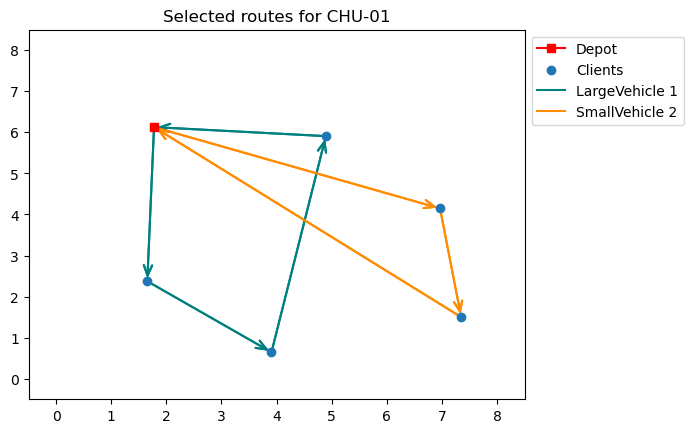

The optimal cost for the distance traveled is: 22.56 €
Route for vehicle k1: 0 -> 2 -> 4 -> 5 -> 0
Route for vehicle k2: 0 -> 1 -> 3 -> 0
Runtime = 0.04896736145019531
---------------------------
Feasibility check:
Total capacity: 45.0
Total amount delivered: 39
Capacity of large vehicles: 30
Amount delivered by vehicle k1: 24
Amount delivered by vehicle k2: 15
All customers are satisfied, capacities are respected, model is feasible


In [24]:
# Optimal solution
############ Instance Initialization CHU-01 ############
name = "CHU-01"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=5,
                                                                     clients=5,
                                                                     S1=1,
                                                                     S2=1,
                                                                     Q1=30,
                                                                     dmin=7,
                                                                     dmax=10)
############ Model1 Construction ############
model1, x, y, u, z, c2 = build_model("model1")

############ Model1 Solving ############
model1.reset()
model1.Params.LogFile = name+".log"
model1.read("MIPStarts\CHU-01.sol")
model1.Params.Heuristics = 0
model1.Params.FlowCoverCuts = 1
model1.optimize()

############ Plotting Solution ############
if model1.solcount >= 1:
#     model1.write(name+"Opt.sol")
#     model1.write(name+".mps")
#     model1.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model1.getAttr('X', x)
    yvals = model1.getAttr('X', y)
    print_route(objective=model1.objVal, edges=selected(vals))
    print(f"Runtime = {model1.runtime}")
    feasibility_check(yvals)
    times.append(model1.runtime)
    objectives.append(model1.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CHU-02</font>**

Discarded solution information
Set parameter LogFile to value "CHU-02.log"
Set parameter Heuristics to value 0
Set parameter FlowCoverCuts to value 1
Set parameter PrePasses to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 456 rows, 280 columns and 1680 nonzeros
Model fingerprint: 0xebff896b
Variable types: 0 continuous, 280 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [9e-01, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]

Loaded user MIP start with objective 67.917

Presolve removed 190 rows and 10 columns
Presolve time: 0.00s
Presolved: 266 rows, 270 columns, 1460 nonzeros
Variable types: 0 continuous, 270 integer (240 binary)

Root relaxation: objective 2.023748e+01, 105 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Ex

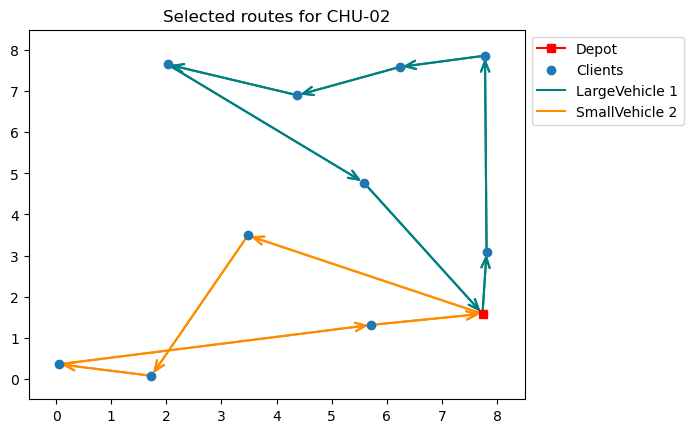

The optimal cost for the distance traveled is: 29.2 €
Route for vehicle k1: 0 -> 6 -> 2 -> 10 -> 1 -> 8 -> 4 -> 0
Route for vehicle k2: 0 -> 9 -> 5 -> 7 -> 3 -> 0
Runtime = 0.6650180816650391
---------------------------
Feasibility check:
Total capacity: 105.0
Total amount delivered: 79
Capacity of large vehicles: 70
Amount delivered by vehicle k1: 46
Amount delivered by vehicle k2: 33
All customers are satisfied, capacities are respected, model is feasible


In [14]:
# Optimal solution
############ Instance Initialization CHU-02 ############
name = "CHU-02"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=4,
                                                                     clients=10,
                                                                     S1=1,
                                                                     S2=1,
                                                                     Q1=70,
                                                                     dmin=7,
                                                                     dmax=10)
############ Model Construction ############
model2, x, y, u, z, c2 = build_model("model2")

############ model2 Solving ############
model2.reset()
model2.Params.LogFile = name+".log"
model2.read("MIPStarts\CHU-02.sol")
model2.Params.Heuristics = 0
model2.Params.FlowCoverCuts = 1
model2.Params.Prepasses = 1
model2.optimize()

############ Plotting Solution ############
if model2.solcount >= 1:
#     model2.write(name+"Opt.sol")
#     model2.write(name+".mps")
#     model2.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model2.getAttr('X', x)
    yvals = model2.getAttr('X', y)
    print_route(objective=model2.objVal, edges=selected(vals))
    print(f"Runtime = {model2.runtime}")
    feasibility_check(yvals)
    times.append(model2.runtime)
    objectives.append(model2.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CHU-03</font>**

Discarded solution information
Set parameter LogFile to value "CHU-03.log"
Set parameter Cuts to value 2
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1464 rows, 855 columns and 5580 nonzeros
Model fingerprint: 0x068bb3e3
Variable types: 0 continuous, 855 integer (765 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [6e-01, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 59.2233398
Presolve removed 633 rows and 0 columns
Presolve time: 0.00s
Presolved: 831 rows, 855 columns, 4905 nonzeros
Crushed 3 out of 3 user cuts to presolved model
Variable types: 0 continuous, 855 integer (765 binary)

Root relaxation: objective 2.042712e+01, 261 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

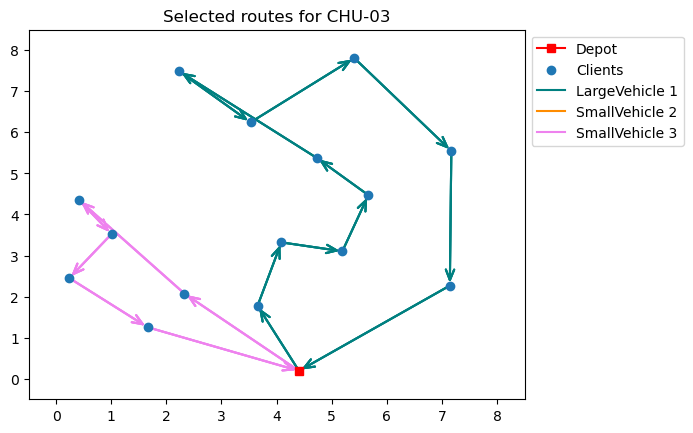

The optimal cost for the distance traveled is: 31.29 €
Route for vehicle k1: 0 -> 11 -> 3 -> 12 -> 1 -> 15 -> 13 -> 9 -> 14 -> 5 -> 4 -> 0
Route for vehicle k2: 0
Route for vehicle k3: 0 -> 2 -> 8 -> 6 -> 10 -> 7 -> 0
Runtime = 4.330377578735352
---------------------------
Feasibility check:
Total capacity: 160.0
Total amount delivered: 118
Capacity of large vehicles: 80
Amount delivered by vehicle k1: 79
Amount delivered by vehicle k2: 0
Amount delivered by vehicle k3: 39
All customers are satisfied, capacities are respected, model is feasible


In [25]:
# Optimal solution
############ Instance Initialization CHU-03 ############
name = "CHU-03"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=3,
                                                                     clients=15,
                                                                     S1=1,
                                                                     S2=2,
                                                                     Q1=80,
                                                                     dmin=7,
                                                                     dmax=10)
############ model3 Construction ############
model3, x, y, u, z, c2 = build_model("model3")
for k in c2:
    c2[k].Lazy = -1

############ model3 Solving ############
model3.reset()
model3.Params.LogFile = name+".log"
model3.Params.Cuts = 2
model3.optimize()

############ Plotting Solution ############
if model3.solcount >= 1:
#     model3.write(name+"Opt.sol")
#     model3.write(name+".mps")
#     model3.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model3.getAttr('X', x)
    yvals = model3.getAttr('X', y)
    print_route(objective=model3.objVal, edges=selected(vals))
    print(f"Runtime = {model3.runtime}")
    feasibility_check(yvals)
    times.append(model3.runtime)
    objectives.append(model3.objVal)

else:
    print("No feasible solution found")

## **<font color="#FBBF44">CHU-04</font>**

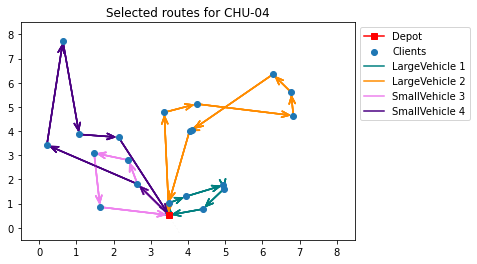

The optimal cost for the distance traveled is: 35.94 €
Route for vehicle k1: 0 -> 3 -> 17 -> 7 -> 10 -> 2 -> 0
Route for vehicle k2: 0 -> 4 -> 11 -> 16 -> 18 -> 15 -> 13 -> 20 -> 3 -> 0
Route for vehicle k3: 0 -> 5 -> 8 -> 14 -> 6 -> 0
Route for vehicle k4: 0 -> 5 -> 1 -> 19 -> 12 -> 9 -> 0
Runtime = 1200.0558834075928
---------------------------
Feasibility check:
Total capacity: 210.0
Total amount delivered: 163
Capacity of large vehicles: 70
Amount delivered by vehicle k1: 41
Amount delivered by vehicle k2: 57
Amount delivered by vehicle k3: 30
Amount delivered by vehicle k4: 35
All customers are satisfied, capacities are respected, model is feasible


In [15]:
# Base Model
############ Instance Initialization CHU-04 ############
name = "CHU-04"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=2,
                                                                     clients=20,
                                                                     S1=2,
                                                                     S2=2,
                                                                     Q1=70,
                                                                     dmin=7,
                                                                     dmax=10)
############ model4 Construction ############
model4, x, y, u, z, c2 = build_model("model4")

############ model4 Solving ############
model4.reset()
model4.Params.LogFile = name+".log"
model4.Params.TimeLimit = timelimCHU
model4.optimize()

############ Plotting Solution ############
if model4.solcount >= 1:
#     model4.write(name+".sol")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model4.getAttr('X', x)
    yvals = model4.getAttr('X', y)
    print_route(objective=model4.objVal, edges=selected(vals))
    print(f"Runtime = {model4.runtime}")
    feasibility_check(yvals)
    times.append(model4.runtime)
    objectives.append(model4.objVal)
else:
    print("No feasible solution found")

Discarded solution information
Set parameter LogFile to value "CHU-04b.log"
Set parameter TimeLimit to value 1200
Set parameter MIPFocus to value 3
Set parameter Cuts to value 2
Set parameter NoRelHeurTime to value 20
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3392 rows, 1920 columns and 13120 nonzeros
Model fingerprint: 0xbc8ff328
Variable types: 0 continuous, 1920 integer (1760 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e-01, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 1520 rows and 0 columns
Presolve time: 0.03s
Presolved: 1872 rows, 1920 columns, 10000 nonzeros
Variable types: 0 continuous, 1920 integer (1760 binary)
Found heuristic solution: objective 124.8183372
Starting NoRel heuristic
Found heuristic solution: objective 117.0586781
Found heuristic solution: objective 106.2788533


 112219 110902   30.98607   42   74   35.81950   30.53555  14.8%  65.8  250s
 114828 113381   31.26423   35   91   35.81950   30.54862  14.7%  65.8  255s
 117400 115950   32.34663   68   51   35.81950   30.56309  14.7%  65.7  260s
 120041 118566   32.15872   31   65   35.81950   30.57889  14.6%  65.7  265s
 122676 121218   31.94294   54  164   35.81950   30.59348  14.6%  65.7  270s
 126029 124445   30.73018   36   95   35.81950   30.61121  14.5%  65.7  276s
 128498 127017   31.02267   33  118   35.81950   30.62684  14.5%  65.7  281s
 131190 129653   32.42051   52  130   35.81950   30.63969  14.5%  65.7  286s
 133727 132246   33.52064   41   58   35.81950   30.65357  14.4%  65.7  291s
 136386 134536   32.81841   35   75   35.81950   30.66568  14.4%  65.7  296s
 138879 137369   30.76949   38  132   35.81950   30.67665  14.4%  65.7  301s
 140752 139213   31.39174   34  113   35.81950   30.68525  14.3%  65.6  305s
 143547 141903   31.04063   31   83   35.81950   30.69743  14.3%  65.6  310s

 348937 345033   31.47471   38  171   35.81950   31.31067  12.6%  65.9  765s
 351039 347067   31.55746   35   99   35.81950   31.31515  12.6%  66.0  770s
 353071 348829   31.97374   39   89   35.81950   31.31953  12.6%  65.9  775s
 354850 350937   32.12440   46   89   35.81950   31.32351  12.6%  66.0  780s
 357142 353055   32.44189   48  112   35.81950   31.32773  12.5%  65.9  785s
 359260 355210   31.88682   41  101   35.81950   31.33204  12.5%  65.9  790s
H361105 356235                      35.8194961   31.33404  12.5%  65.9  793s
 361363 357194   31.85988   40  101   35.81950   31.33534  12.5%  65.9  795s
 363514 359418   31.49149   39  111   35.81950   31.33997  12.5%  65.9  801s
 365689 361557   31.47762   41   98   35.81950   31.34448  12.5%  65.9  806s
 367778 363653   31.65264   41  104   35.81950   31.34861  12.5%  65.9  811s
 369868 365700   33.74837   52   75   35.81950   31.35267  12.5%  65.9  816s
 372053 367877   33.53893   37   84   35.81950   31.35690  12.5%  65.9  821s

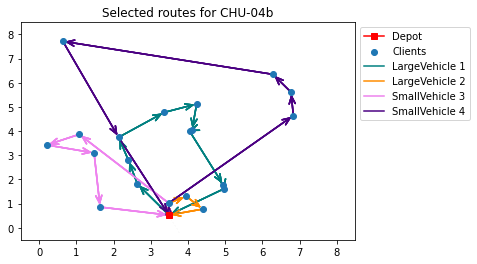

The optimal cost for the distance traveled is: 35.82 €
Route for vehicle k1: 0 -> 5 -> 8 -> 9 -> 4 -> 11 -> 13 -> 20 -> 7 -> 10 -> 0
Route for vehicle k2: 0 -> 3 -> 17 -> 2 -> 0
Route for vehicle k3: 0 -> 3 -> 12 -> 1 -> 14 -> 6 -> 0
Route for vehicle k4: 0 -> 3 -> 16 -> 18 -> 15 -> 19 -> 9 -> 0
Runtime = 1200.1114616394043
---------------------------
Feasibility check:
Total capacity: 210.0
Total amount delivered: 163
Capacity of large vehicles: 70
Amount delivered by vehicle k1: 69
Amount delivered by vehicle k2: 25
Amount delivered by vehicle k3: 34
Amount delivered by vehicle k4: 35
All customers are satisfied, capacities are respected, model is feasible


In [16]:
# Param tweaking
############ Instance Initialization CHU-04 ############
name = "CHU-04b"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=2,
                                                                     clients=20,
                                                                     S1=2,
                                                                     S2=2,
                                                                     Q1=70,
                                                                     dmin=7,
                                                                     dmax=10)
############ model4 Construction ############
model4b, x, y, u, z, c2 = build_model("model4b")

############ model4 Solving ############
model4b.reset()
model4b.Params.LogFile = name+".log"
model4b.Params.TimeLimit = timelimCHU
model4b.Params.MIPFocus = 3
model4b.Params.Cuts = 2
model4b.Params.NoRelHeurTime = 20
model4b.optimize()

############ Plotting Solution ############
if model4b.solcount >= 1:
#     model4b.write(name+".sol")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model4b.getAttr('X', x)
    yvals = model4b.getAttr('X', y)
    print_route(objective=model4b.objVal, edges=selected(vals))
    print(f"Runtime = {model4b.runtime}")
    feasibility_check(yvals)
    times.append(model4b.runtime)
    objectives.append(model4b.objVal)
else:
    print("No feasible solution found")

Discarded solution information
Set parameter LogFile to value "CHU-04c.log"
Set parameter TimeLimit to value 1200
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3392 rows, 1920 columns and 13120 nonzeros
Model fingerprint: 0xdda5fbd2
Variable types: 0 continuous, 1920 integer (1760 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e-01, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]

Loaded user MIP start with objective 124.818

Presolve removed 1520 rows and 0 columns
Presolve time: 0.03s
Presolved: 1872 rows, 1920 columns, 10000 nonzeros
Variable types: 0 continuous, 1920 integer (1760 binary)

Root relaxation: objective 2.409883e+01, 523 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap |

 151030 96305   31.71988   70  145   36.32373   29.57333  18.6%  30.8  235s
 154547 99222   34.88306  138  128   36.32373   29.58420  18.6%  30.9  240s
 158708 102261   32.16432   65  100   36.32373   29.59738  18.5%  31.0  245s
 161823 104454   33.45287   78   72   36.32373   29.60959  18.5%  31.1  250s
 165428 107164   32.51288   81  133   36.32373   29.62214  18.4%  31.1  255s
 168567 109174   31.61081   69  125   36.32373   29.63448  18.4%  31.3  260s
 172049 111965   32.96377   69  162   36.32373   29.64635  18.4%  31.3  265s
 176431 114872   32.32293  130  214   36.32373   29.65985  18.3%  31.4  271s
 179806 117442   33.41623  121   72   36.32373   29.67212  18.3%  31.4  275s
 183314 120069   33.36046   92  142   36.32373   29.68379  18.3%  31.4  280s
 186515 122471   30.82772   62  165   36.32373   29.69446  18.3%  31.4  285s
 190742 125611   31.87738   82  115   36.32373   29.70617  18.2%  31.5  291s
 193950 127787   34.46873   96  128   36.32373   29.71847  18.2%  31.5  295s
 

 429007 301495   31.74090   66  135   36.32372   30.21452  16.8%  34.5  721s
 430591 302970   34.87887  109  164   36.32372   30.21739  16.8%  34.5  725s
 432884 304525   33.10712   98  153   36.32372   30.22186  16.8%  34.6  731s
 434535 305860   32.39995  114  143   36.32372   30.22430  16.8%  34.6  735s
 437055 307633   32.23473   79  142   36.32372   30.22909  16.8%  34.7  741s
 438748 308952   33.30115   89  222   36.32372   30.23183  16.8%  34.7  746s
 440484 310273   33.45584   75   51   36.32372   30.23389  16.8%  34.7  750s
 443231 312233   32.51671   97   97   36.32372   30.23752  16.8%  34.8  756s
 445486 313781   35.26982   91   86   36.32372   30.24027  16.7%  34.8  761s
 447286 315027   31.96976   83  126   36.32372   30.24266  16.7%  34.8  765s
 448943 315718   34.17776  103  149   36.32372   30.24505  16.7%  34.9  772s
 449878 316792   33.50702   89  151   36.32372   30.24689  16.7%  34.9  776s
 451229 317963   32.14771   81  122   36.32372   30.24887  16.7%  34.9  780s

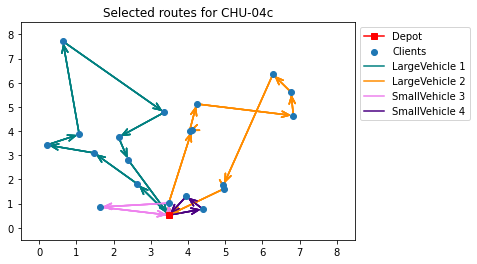

The optimal cost for the distance traveled is: 36.32 €
Route for vehicle k1: 0 -> 5 -> 14 -> 1 -> 12 -> 19 -> 4 -> 9 -> 8 -> 0
Route for vehicle k2: 0 -> 3 -> 13 -> 20 -> 11 -> 16 -> 18 -> 15 -> 7 -> 10 -> 0
Route for vehicle k3: 0 -> 3 -> 6 -> 0
Route for vehicle k4: 0 -> 2 -> 17 -> 0
Runtime = 1200.1006984710693
---------------------------
Feasibility check:
Total capacity: 210.0
Total amount delivered: 163
Capacity of large vehicles: 70
Amount delivered by vehicle k1: 63
Amount delivered by vehicle k2: 70
Amount delivered by vehicle k3: 14
Amount delivered by vehicle k4: 16
All customers are satisfied, capacities are respected, model is feasible


In [17]:
# Base Model + MIPStart
############ Instance Initialization CHU-04 ############
name = "CHU-04c"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=2,
                                                                     clients=20,
                                                                     S1=2,
                                                                     S2=2,
                                                                     Q1=70,
                                                                     dmin=7,
                                                                     dmax=10)
############ model4 Construction ############
model4c, x, y, u, z, c2 = build_model("model4c")

############ model4 Solving ############
model4c.reset()
model4c.Params.LogFile = name+".log"
model4c.Params.TimeLimit = timelimCHU
model4c.read("MIPStarts\CHU-04.sol")
model4c.optimize()

############ Plotting Solution ############
if model4c.solcount >= 1:
#     model4c.write(name+".sol")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model4c.getAttr('X', x)
    yvals = model4c.getAttr('X', y)
    print_route(objective=model4c.objVal, edges=selected(vals))
    print(f"Runtime = {model4c.runtime}")
    feasibility_check(yvals)
    times.append(model4c.runtime)
    objectives.append(model4c.objVal)
else:
    print("No feasible solution found")

Discarded solution information
Set parameter LogFile to value "CHU-04d.log"
Set parameter TimeLimit to value 1200
Set parameter Cuts to value 2
Set parameter NoRelHeurTime to value 40
Set parameter MIPFocus to value 3
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3392 rows, 1920 columns and 13120 nonzeros
Model fingerprint: 0xbd4f34ed
Variable types: 0 continuous, 1920 integer (1760 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e-01, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]

Loaded user MIP start with objective 124.818

Presolve removed 1524 rows and 0 columns
Presolve time: 0.06s
Presolved: 1868 rows, 1920 columns, 10000 nonzeros
Crushed 4 out of 4 user cuts to presolved model
Variable types: 0 continuous, 1920 integer (1760 binary)
Starting NoRel heuristic
Found heuristic solution: objective 117.1308260
F

 58194 57093   31.14869   29  167   35.10123   29.83475  15.0%  67.6  230s
 59970 57963   32.11869   21   75   35.10123   29.86109  14.9%  67.6  239s
 59994 58919   30.49729   45  129   35.10123   29.86257  14.9%  67.6  242s
 61810 60366   30.60416   40   84   35.10123   29.88383  14.9%  67.7  246s
 63366 62036   30.39677   42  149   35.10123   29.90252  14.8%  67.8  251s
 65058 63707   30.19843   31  125   35.10123   29.92245  14.8%  67.9  256s
 66799 65452   30.58194   34  131   35.10123   29.94438  14.7%  68.0  260s
 68527 67190   31.75871   48  100   35.10123   29.96129  14.6%  68.1  265s
 70376 68901   30.15658   46   94   35.10123   29.97829  14.6%  68.0  270s
 72855 71047   31.91397   48   60   35.10123   30.00363  14.5%  68.1  276s
 74157 72700   30.34271   39  148   35.10123   30.01610  14.5%  68.2  282s
 75837 74322   30.36255   22  118   35.10123   30.03533  14.4%  68.2  286s
 77438 75847   32.07180   64   58   35.10123   30.05033  14.4%  68.2  290s
 79086 77432   30.23418  

 212746 209046   33.44312   43   91   35.02304   30.71301  12.3%  67.7  768s
 213707 210005   32.58756   50   96   35.02304   30.71604  12.3%  67.7  771s
 214670 210952   30.95591   53   92   35.02304   30.71875  12.3%  67.7  775s
 216608 212887   31.01399   24   65   35.02304   30.72485  12.3%  67.7  783s
 217591 213825   32.94281   47  111   35.02304   30.72779  12.3%  67.7  787s
 218555 214542   31.90005   38  133   35.02304   30.73074  12.3%  67.7  792s
 219284 215477   31.24240   37   74   35.02304   30.73203  12.3%  67.7  796s
 220232 216511   31.71724   38   92   35.02304   30.73502  12.2%  67.7  800s
 222286 218449   31.31009   47  132   35.02304   30.74058  12.2%  67.7  808s
 223253 219419   32.00793   47  151   35.02304   30.74313  12.2%  67.7  813s
 224247 220336   30.90471   43   96   35.02304   30.74673  12.2%  67.6  817s
 225180 221243   32.16183   40   77   35.02304   30.74895  12.2%  67.6  820s
 226098 222204   33.02009   40  129   35.02304   30.75200  12.2%  67.6  825s

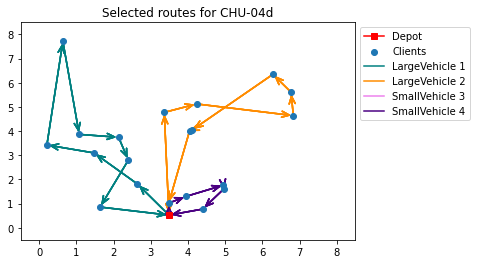

The optimal cost for the distance traveled is: 35.02 €
Route for vehicle k1: 0 -> 5 -> 14 -> 1 -> 19 -> 12 -> 9 -> 8 -> 6 -> 0
Route for vehicle k2: 0 -> 4 -> 11 -> 16 -> 18 -> 15 -> 13 -> 20 -> 3 -> 0
Route for vehicle k3: 0
Route for vehicle k4: 0 -> 3 -> 17 -> 7 -> 10 -> 2 -> 0
Runtime = 1200.2478008270264
---------------------------
Feasibility check:
Total capacity: 210.0
Total amount delivered: 163
Capacity of large vehicles: 70
Amount delivered by vehicle k1: 65
Amount delivered by vehicle k2: 66
Amount delivered by vehicle k3: 0
Amount delivered by vehicle k4: 32
All customers are satisfied, capacities are respected, model is feasible


In [18]:
# MIPStart + Params + user cuts
############ Instance Initialization CHU-04 ############
name = "CHU-04d"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=2,
                                                                     clients=20,
                                                                     S1=2,
                                                                     S2=2,
                                                                     Q1=70,
                                                                     dmin=7,
                                                                     dmax=10)
############ model4 Construction ############
model4d, x, y, u, z, c2 = build_model("model4d")
for k in c2:
    c2[k].Lazy = -1

############# model4 Solving ############
model4d.reset()
model4d.Params.LogFile = name+".log"
model4d.Params.TimeLimit = 1200
model4d.Params.Cuts = 2
model4d.Params.NoRelHeurTime = 40
model4d.Params.MIPFocus = 3
model4d.read("MIPStarts\CHU-04.sol")
model4d.optimize()

############ Plotting Solution ############
if model4d.solcount >= 1:
#     model4d.write(name+".sol")
#     model4d.write(name+".mps")
#     model4d.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model4d.getAttr('X', x)
    yvals = model4d.getAttr('X', y)
    print_route(objective=model4d.objVal, edges=selected(vals))
    print(f"Runtime = {model4d.runtime}")
    feasibility_check(yvals)
    times.append(model4d.runtime)
    objectives.append(model4d.objVal)
else:
    print("No feasible solution found")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-14
Discarded solution information
Set parameter LogFile to value "CHU-04e.log"
Set parameter TimeLimit to value 1200
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4916 rows, 1920 columns and 19280 nonzeros
Model fingerprint: 0x4ef41f53
Variable types: 0 continuous, 1920 integer (1760 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e-01, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 3044 rows and 0 columns
Presolve time: 0.04s
Presolved: 1872 rows, 1920 columns, 10080 nonzeros
Crushed 4 out of 4 user cuts to presolved model
Variable types: 0 continuous, 1920 integer (1760 binary)

Root relaxation: objective 2.060256e+01, 416 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Obje

 200929 52926   34.93078   51  184   35.60479   32.85286  7.73%  42.2  240s
 205158 54003     cutoff   55        35.60479   32.88704  7.63%  42.4  245s
 208217 54768 infeasible   56        35.60479   32.90813  7.57%  42.5  250s
 211986 55648 infeasible   53        35.60479   32.94345  7.47%  42.6  256s
 215490 56549     cutoff   59        35.60479   32.96676  7.41%  42.7  260s
 218652 57131   34.58568   50  112   35.60479   32.99756  7.32%  42.8  265s
 222905 58171   34.14010   63  222   35.60479   33.02950  7.23%  42.9  270s
 226773 58962   35.02164   56  207   35.60479   33.05542  7.16%  43.0  275s
 230818 59927   34.50967   56  155   35.60479   33.08486  7.08%  43.1  280s
 234324 60666   35.59509   72  110   35.60479   33.10906  7.01%  43.1  285s
 238227 61337   35.60096   50  156   35.60479   33.13898  6.93%  43.2  290s
 241648 62055   34.26521   49  148   35.60479   33.16030  6.87%  43.3  295s
 245398 62964   34.17139   50  153   35.60479   33.18596  6.79%  43.4  300s
 248728 6362

Best objective 3.514027981589e+01, best bound 3.513874091606e+01, gap 0.0044%


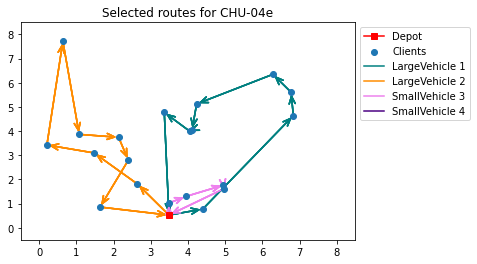

The optimal cost for the distance traveled is: 35.14 €
Route for vehicle k1: 0 -> 2 -> 16 -> 18 -> 15 -> 11 -> 13 -> 20 -> 4 -> 0
Route for vehicle k2: 0 -> 5 -> 14 -> 1 -> 19 -> 12 -> 9 -> 8 -> 6 -> 0
Route for vehicle k3: 0 -> 3 -> 17 -> 7 -> 10 -> 0
Route for vehicle k4: 0
Runtime = 725.956953048706
---------------------------
Feasibility check:
Total capacity: 210.0
Total amount delivered: 163
Capacity of large vehicles: 70
Amount delivered by vehicle k1: 66
Amount delivered by vehicle k2: 65
Amount delivered by vehicle k3: 32
Amount delivered by vehicle k4: 0
All customers are satisfied, capacities are respected, model is feasible


In [11]:
# Optimal solution = User cuts + Constraints
############ Instance Initialization CHU-04 ############
name = "CHU-04e"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=2,
                                                                     clients=20,
                                                                     S1=2,
                                                                     S2=2,
                                                                     Q1=70,
                                                                     dmin=7,
                                                                     dmax=10)
############ model4 Construction ############
model4e, x, y, u, z, c2 = build_model("model4e")
for k in c2:
    c2[k].Lazy = -1

model4e.addConstrs(quicksum(d[j]*x[i,j,k] for j in N for i in V if i!=j) <= Q[k] for k in K)
model4e.addConstrs(u[i,k] - u[j,k] + n*x[i,j,k] <= n-1 for i, j in A if i != 0 and j != 0 for k in K)

############ model4 Solving ############
model4e.reset()
model4e.Params.LogFile = name+".log"
model4e.Params.TimeLimit = timelimCHU
model4e.optimize()

############ Plotting Solution ############
if model4e.solcount >= 1:
    model4e.write(name+"opt.sol")
#     model4e.write(name+".mps")
#     model4e.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model4e.getAttr('X', x)
    yvals = model4e.getAttr('X', y)
    print_route(objective=model4e.objVal, edges=selected(vals))
    times.append(model4e.runtime)
    print(f"Runtime = {model4e.runtime}")
    feasibility_check(yvals)
    objectives.append(model4e.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CHU-05</font>**

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-14
Discarded solution information
Set parameter LogFile to value "CHU-05.log"
Set parameter TimeLimit to value 1200
Set parameter Cuts to value 2
Set parameter NoRelHeurTime to value 400
Set parameter MIPFocus to value 3
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6545 rows, 3625 columns and 28625 nonzeros
Model fingerprint: 0xeaedf1f1
Variable types: 0 continuous, 3625 integer (3375 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e-01, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 3005 rows and 0 columns
Presolve time: 0.08s
Presolved: 3540 rows, 3625 columns, 19500 nonzeros
Crushed 5 out of 5 user cuts to presolved model
Variable types: 0 continuous, 3625 integer (3375 binary)
Starting NoRel heuristic
Found

     0     0   39.01572    0  181   46.43543   39.01572  16.0%     -  402s
     0     0   39.34617    0  213   46.43543   39.34617  15.3%     -  402s
     0     0   39.34766    0  227   46.43543   39.34766  15.3%     -  402s
     0     0   39.44865    0  241   46.43543   39.44865  15.0%     -  403s
     0     0   39.50275    0  262   46.43543   39.50275  14.9%     -  403s
     0     0   39.50382    0  273   46.43543   39.50382  14.9%     -  403s
     0     0   39.72988    0  222   46.43543   39.72988  14.4%     -  403s
     0     0   39.72988    0  217   46.43543   39.72988  14.4%     -  403s
     0     0   39.75062    0  260   46.43543   39.75062  14.4%     -  404s
     0     0   39.75062    0  260   46.43543   39.75062  14.4%     -  404s
     0     2   39.79213    0  260   46.43543   39.79213  14.3%     -  404s
     3     8   39.81970    2  173   46.43543   39.81970  14.2%  98.3  405s
   121   123   41.40250    9  232   46.43543   41.14460  11.4%   184  410s
   328   324   44.92423  

 96632 69495   46.31381   26  135   46.43543   44.66109  3.82%  85.1  907s
 97615 70037   45.75516   33  273   46.43543   44.66733  3.81%  85.1  912s
 98560 70715     cutoff   37        46.43543   44.67361  3.79%  85.1  916s
 99597 71390     cutoff   42        46.43543   44.68034  3.78%  85.0  921s
 100668 71945     cutoff   36        46.43543   44.68609  3.77%  85.0  925s
 101551 72629   45.02809   37  123   46.43543   44.69128  3.76%  85.0  930s
 103652 73971   45.94877   34   42   46.43543   44.70363  3.73%  84.9  939s
 104718 74605   45.98110   49   59   46.43543   44.70939  3.72%  84.8  943s
 105733 75273   44.72205   37  215   46.43543   44.71592  3.70%  84.9  948s
 106806 75814   44.84773   33  188   46.43543   44.72360  3.69%  84.8  952s
 107665 76477   44.97694   23  154   46.43543   44.72752  3.68%  84.8  957s
 108713 77214   45.19648   28  190   46.43543   44.73441  3.66%  84.8  962s
 109966 77812   44.78702   35  160   46.43543   44.74042  3.65%  84.7  966s
 110956 78407   

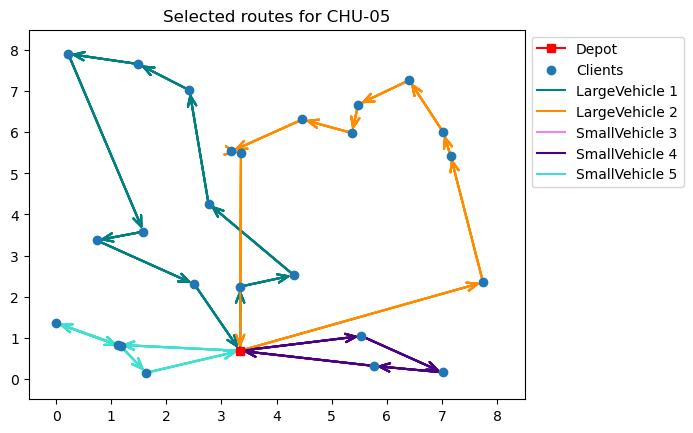

The optimal cost for the distance traveled is: 46.44 €
Route for vehicle k1: 0 -> 16 -> 9 -> 7 -> 3 -> 6 -> 14 -> 19 -> 5 -> 22 -> 0
Route for vehicle k2: 0 -> 21 -> 25 -> 13 -> 20 -> 11 -> 15 -> 17 -> 8 -> 10 -> 0
Route for vehicle k3: 0
Route for vehicle k4: 0 -> 23 -> 24 -> 1 -> 0
Route for vehicle k5: 0 -> 18 -> 2 -> 4 -> 12 -> 0
Runtime = 1200.0997047424316
---------------------------
Feasibility check:
Total capacity: 262.5
Total amount delivered: 199
Capacity of large vehicles: 75
Amount delivered by vehicle k1: 75
Amount delivered by vehicle k2: 69
Amount delivered by vehicle k3: 0
Amount delivered by vehicle k4: 23
Amount delivered by vehicle k5: 32
All customers are satisfied, capacities are respected, model is feasible


In [10]:
# User cuts + Params + 
############ Instance Initialization CHU-05 ############
name = "CHU-05"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=1,
                                                                     clients=25,
                                                                     S1=2,
                                                                     S2=3,
                                                                     Q1=75,
                                                                     dmin=7,
                                                                     dmax=10)
############ model5 Construction ############
model5, x, y, u, z, c2 = build_model("model5")
for k in c2:
    c2[k].Lazy = -1
    
model5.addConstrs(quicksum(d[j]*x[i,j,k] for j in N for i in V if i!=j) <= Q[k] for k in K)

############ model5 Solving ############
model5.reset()
model5.Params.LogFile = name+".log"
model5.Params.TimeLimit = 1200  # Time limit
model5.Params.Cuts = 2
model5.Params.NoRelHeurTime = 400
model5.Params.MIPFocus = 3
model5.optimize()

############ Plotting Solution ############
if model5.solcount >= 1:
    model5.write(name+"best.sol")
#     model5.write(name+".mps")
#     model5.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model5.getAttr('X', x)
    yvals = model5.getAttr('X', y)
    print_route(objective=model5.objVal, edges=selected(vals))
    times.append(model5.runtime)
    print(f"Runtime = {model5.runtime}")
    feasibility_check(yvals)
    objectives.append(model5.objVal)
else:
    print("No feasible solution found")

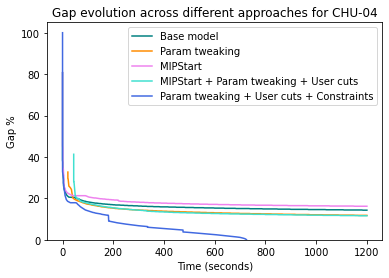

In [103]:
# Comparing gap evolution with different approaches solving CHU-05 
gaps, runtime, incumbent, bestbd = gap_runtime("Logs\CHU-04")
gapsb, runtimeb, incumbentb, bestbdb = gap_runtime("Logs\CHU-04b")
gapsc, runtimec, incumbentc, bestbdc = gap_runtime("Logs\CHU-04c")
gapsd, runtimed, incumbentd, bestbdd = gap_runtime("Logs\CHU-04d")
gapse, runtimee, incumbente, bestbde = gap_runtime("Logs\CHU-04e")

plt.plot(runtime, gaps, color="teal", label="Base model")
plt.plot(runtimeb, gapsb, color="darkorange", label="Param tweaking")
plt.plot(runtimec, gapsc, color="violet", label="MIPStart")
plt.plot(runtimed, gapsd, color="turquoise", label="MIPStart + Param tweaking + User cuts")
plt.plot(runtimee, gapse, color="royalblue", label="Param tweaking + User cuts + Constraints")
plt.title("Gap evolution across different approaches for CHU-04")
plt.legend(loc='best')
plt.xlabel("Time (seconds)")
plt.ylim(0)
plt.ylabel("Gap %")
plt.savefig("FigXX-GapComparisonCHU-04.png", bbox_inches='tight', dpi=300)
plt.show()

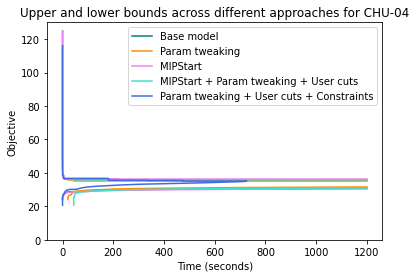

In [104]:
plt.plot(runtime, incumbent, color="teal", label="Base model")
plt.plot(runtimeb, incumbentb, color="darkorange", label="Param tweaking")
plt.plot(runtimec, incumbentc, color="violet", label="MIPStart")
plt.plot(runtimed, incumbentd, color="turquoise", label="MIPStart + Param tweaking + User cuts")
plt.plot(runtimee, incumbente, color="royalblue", label="Param tweaking + User cuts + Constraints")

plt.plot(runtime, bestbd, color="teal")
plt.plot(runtimeb, bestbdb, color="darkorange")
plt.plot(runtimec, bestbdc, color="violet")
plt.plot(runtimed, bestbdd, color="turquoise")
plt.plot(runtimee, bestbde, color="royalblue")
plt.title("Upper and lower bounds across different approaches for CHU-04")
plt.legend(loc='best')
plt.xlabel("Time (seconds)")
plt.ylim(0)
plt.ylabel("Objective")
plt.savefig("FigXX-BoundsComparisonCHU-04.png", bbox_inches='tight', dpi=300)
plt.show()